# Hough Transform

Your code will take as input a greyscale image *im*, (torch.Tensor with dtype torch.uint8 and shape (H, W)). You then need to:

1. Apply an edge detector.
2. Apply the Hough transform for circles, using the corresponding OpenCV function.

The code is expected to show the final result using pyplot (e.g. calling the imshow function).

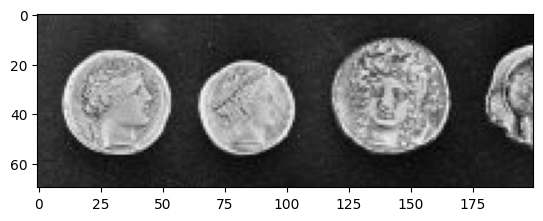

In [1]:
from io import BytesIO
import numpy as np
import cv2
import torch
from skimage import data
from matplotlib import pyplot as plt
from torch import nn

im = torch.from_numpy(data.coins()[160:230, 70:270])
plt.imshow(im, cmap='gray')


In [14]:
class GradientGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        s_x = torch.tensor([[-1,0,1], [-2,0,2], [-1,0,1]], dtype=torch.float32)
        s_y = torch.tensor([[1,2,1], [0,0,0], [-1,-2,-1]], dtype=torch.float32)
        sobel= torch.stack((s_x, s_y), 0)
        sobel = sobel.unsqueeze(1)

        self.gradientsConv = nn.Conv2d(
            in_channels= 1,
            out_channels= 2,
            kernel_size= [sobel.shape[1], sobel.shape[2]],
            stride=1,
            padding=0,
            bias=False
        )

        weights = nn.parameter.Parameter(data=sobel, requires_grad=False)
        self.gradientsConv.weight = weights

    def forward(self, X):
        with torch.no_grad():
            grads = self.gradientsConv(X)
            mG = torch.sqrt(torch.pow(grads[0], 2) + torch.pow(grads[1], 2))
            max = mG.max()
            mG = mG *255/max
            mG = (torch.floor(mG)).to(torch.uint8)
            return mG

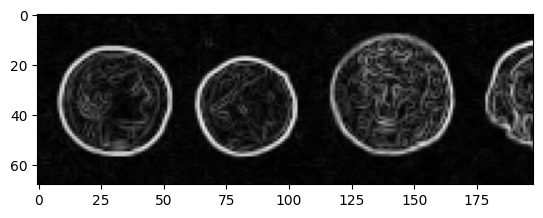

In [17]:
model = GradientGenerator()

grad = model(im.to(torch.float32).unsqueeze(0))

plt.imshow(grad, cmap="gray")

circles:  (1, 3, 3)


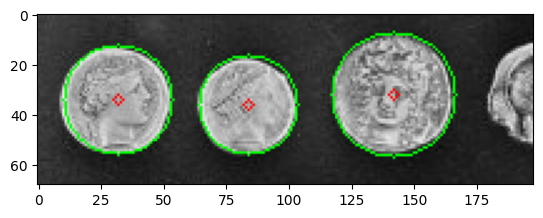

In [82]:
img = im[1:-1,1:-1].clone().numpy()

circles = cv2.HoughCircles(grad.numpy(), cv2.HOUGH_GRADIENT,1,30,
                            param1=1000,param2=20,minRadius=0,maxRadius=0)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

                            
circles = np.uint16(np.around(circles))
print("circles: ", circles.shape)

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),1)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(255,0,0),1)

plt.imshow(img)